#1. Installs and Imports

In [ ]:
# # Install NumPy for numerical operations on arrays
# !pip install numpy

# # Install Gym for creating and managing reinforcement learning environments
# !pip install gym

# # Install Optuna for hyperparameter optimization
!pip install optuna

# # Install Matplotlib for plotting data and creating visualizations
# !pip install matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.5 MB/s eta 0:00:00


In [ ]:
# Standard libraries
import random  # For generating random numbers and sampling from distributions

# External libraries (third-party)
import time  # For tracking the exqcution of a program
import numpy as np  # For numerical operations on arrays
import gym  # For creating and managing reinforcement learning environments
from gym import spaces  # For defining custom action and observation spaces in Gym
from gym.utils import seeding  # For seeding random number generators in Gym
import optuna  # For optimizing hyperparameters

# Visualization libraries
import matplotlib.pyplot as plt  # For plotting data
import matplotlib.patches as patches  # For creating custom shapes on plots

# Set a seed
random_seed = 25
# Ensure random sampling occurs according to the seed to ensure results are replicable
rng = random.Random()
rng.seed(random_seed)

#2. Maze

## 2.1. Maze Elements

In [ ]:
AGENT = "A"  # the agent's current position
WALL = "1"  # wall (unpassable)
PATH = "0"  # open path (passable)
START = "S"  # starting position of the agent
SUB_GOAL = "G"  # sub-goal
END = "E"  # end goal

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 2.2. Maze Layout

In [ ]:
# Define the maze layout
maze = np.array([
    [WALL, WALL, WALL, WALL, WALL, WALL, WALL, WALL, WALL, WALL],
    [WALL, PATH, WALL, PATH, PATH, PATH, WALL, PATH, PATH, WALL],
    [WALL, PATH, WALL, PATH, WALL, PATH, WALL, PATH, WALL, WALL],
    [WALL, PATH, PATH, PATH, WALL, PATH, PATH, PATH, PATH, WALL],
    [WALL, WALL, WALL, PATH, WALL, WALL, WALL, WALL, PATH, WALL],
    [WALL, PATH, WALL, PATH, PATH, PATH, PATH, WALL, PATH, WALL],
    [WALL, PATH, PATH, PATH, WALL, WALL, PATH, PATH, PATH, WALL],
    [WALL, WALL, WALL, PATH, WALL, PATH, WALL, WALL, PATH, WALL],
    [WALL, PATH, PATH, PATH, PATH, PATH, WALL, PATH, PATH, WALL],
    [WALL, WALL, WALL, WALL, WALL, WALL, WALL, WALL, WALL, WALL]
], dtype=object)

# Set the positions
start_pos = (1, 1)  # S
end_pos = (7, 8)  # E
sub_goal_pos = (5, 3)  # G (3, 8) used for testing

# Place the start, end, and sub-goal  in the maze
maze[start_pos] = START
maze[end_pos] = END
maze[sub_goal_pos] = SUB_GOAL

##2.3. Maze Environment without Sub-goal

In [ ]:
class MazeEnv1(gym.Env):
    def __init__(self):
        """
        Initializes the Maze environment. Sets up the action space (4 directions), observation space
        (100 states: 10x10 grid), and initializes the maze, agent position, and other variables.
        """
        super(MazeEnv1, self).__init__()
        # Define the action space (up, down, left, right) and the observation space
        self.action_space = spaces.Discrete(4)  # All possible directions (up, down, left, right)
        self.observation_space = spaces.Discrete(100)  # 10x10 grid -> 100 states
        # Copy the maze layout and set the starting position
        self.maze = np.copy(maze)
        self.position = start_pos
        self.goal_reached = False
        self.seed(random_seed)
        # Define the colormap for rendering the maze
        self.colormap = {
            WALL: 'black',
            PATH: 'white',
            END: 'limegreen',
            AGENT: 'red',
            START: 'gold'}

    def step(self, action):
        """
        Executes an action in the environment. Moves the agent according to the action,
        calculates rewards and checks if the agent has reached the end-goal.
        Returns the new state, reward, done (True if the end-goal is reached), and additional info.
        """
        # Map action numbers to movement directions
        movements = {
            0: (-1, 0), # up
            1: (1, 0),  # down
            2: (0, -1), # left
            3: (0, 1)   # right
            }
        # Get the current position of the agent
        x, y = self.position
        dx, dy = movements[action]
        new_x, new_y = x + dx, y + dy

        # Prevent movement out of bounds (agent stays in place if the move is outside the grid)
        if new_x < 0 or new_x >= self.maze.shape[0] or new_y < 0 or new_y >= self.maze.shape[1]:
          new_x, new_y = x, y  # Stay in the same place if out of bounds

        # Check if the next position is a wall, and if so, the agent stays in the same place
        if self.maze[new_x, new_y] == WALL:
            new_x, new_y = x, y
            reward = -1  # Negative reward for hitting a wall
        else:
            reward = -0.1  # Small penalty for movement

        # Update the agent's position
        self.position = (new_x, new_y)

        # Check if the agent reached the goal, and give a large reward if true
        if self.position == end_pos:
                reward = 10  # Large reward for reaching the goal
                self.goal_reached = True

        # Determine if the episode is done (i.e., the agent reached the goal)
        done = self.goal_reached
        # Encode the state as a single number (row * grid_width + column)
        new_state = (new_x * 10 + new_y)  # State encoding
        return new_state, reward, done, {}

    def seed(self, seed=None):
        """
        Set the seed for the environment's random number generators.
        """
        self.np_random, seed = seeding.np_random(seed)
        self.action_space.seed(seed)

    def reset(self):
        """
        Resets the environment to its initial state. The agent is placed at the start position,
        and goal status is reset.
        Returns the starting state.
        """
        # Reset the position to the starting position and reset the goal flag
        self.position = start_pos
        self.goal_reached = False
        self.seed(random_seed)
        # Return the encoded starting state
        return self.position[0] * 10 + self.position[1]

    def render(self, mode='human'):
        """
        Render the maze in a textual form.
        """
        # Copy the current state of the maze
        temp_maze = np.copy(self.maze)
        # Get the current position of the agent
        x, y = self.position
        # Mark the agent's position or the goal if reached
        temp_maze[x][y] = AGENT if not self.goal_reached else END
        # Print the maze with the agent's current position
        for row in temp_maze:
            print(' '.join(row))
        print()

    def colorful_render(self, mode='human', ax=None):
        """
        Renders the maze using a graphical representation with colors for different maze elements (walls, paths, goals).
        Plots the agent as a red circle on the maze.
        """
        # Copy the maze layout
        temp_maze = np.copy(self.maze)

        # Loop over each cell in the maze
        for i in range(temp_maze.shape[0]):
            for j in range(temp_maze.shape[1]):
                # Choose the appropriate color based on the maze element
                if temp_maze[i, j] == PATH or temp_maze[i, j] == SUB_GOAL:
                    color = self.colormap[PATH]
                elif temp_maze[i, j] == START:
                    color = self.colormap[START]
                elif temp_maze[i, j] == END:
                    color = self.colormap[END]
                else:
                    color = self.colormap[WALL]

                # Draw a colored square for each cell
                ax.add_patch(patches.Rectangle((j, temp_maze.shape[0] - i - 1), 1, 1, facecolor=color)) # Invert y-axis and plot each cell as a square

        # Plot the agent as a red circle on the grid
        x, y = self.position
        agent = patches.Circle((y + 0.5, temp_maze.shape[0] - x - 0.5), 0.3, color=self.colormap[AGENT]) # Plot the agent as a red circle
        ax.add_patch(agent)

        # Set up axes limits
        ax.set_xlim(0, temp_maze.shape[1])
        ax.set_ylim(0, temp_maze.shape[0])
        ax.set_aspect('equal')
        ax.set_xticks([])   # Remove x-axis ticks
        ax.set_yticks([])   # Remove y-axis ticks

    def visualize_policy(self, q_table):
        """
        Visualize the learned policy using arrows to represent actions.
        """
        # Set up the plot for rendering
        _, ax = plt.subplots()
        temp_maze = np.copy(self.maze)

        # Loop over each cell and apply color based on the cell type
        for i in range(temp_maze.shape[0]):
            for j in range(temp_maze.shape[1]):
                if temp_maze[i, j] == PATH or temp_maze[i, j] == SUB_GOAL:
                    color = self.colormap[PATH]
                elif temp_maze[i, j] == START:
                    color = self.colormap[START]
                elif temp_maze[i, j] == END:
                    color = self.colormap[END]
                else:
                    color = self.colormap[WALL]

                # Draw each cell as a colored rectangle
                ax.add_patch(patches.Rectangle((j, temp_maze.shape[0] - i - 1), 1, 1, facecolor=color))  # Invert y-axis and plot each cell as a square

        # Add arrows to represent the learned policy for each state
        for i in range(temp_maze.shape[0]):
            for j in range(temp_maze.shape[1]):
                state = i * temp_maze.shape[1] + j
                if temp_maze[i, j] != WALL and temp_maze[i, j] != END:
                    # Skip states where all Q-values are equal (no preferred action)
                    if len(np.unique(q_table[state])) == 1: # Check if all Q-values for this state are equal to each other
                        continue

                    # Determine the best action according to the Q-table
                    action = np.argmax(q_table[state])
                    # Draw arrows based on the action (up, down, left, right)
                    if action == 0:  # Up
                        ax.arrow(j + 0.4, temp_maze.shape[0] - i - 0.75, 0, 0.3, head_width=0.1, head_length=0.1, fc='black', ec='black')
                    elif action == 1:  # Down
                        ax.arrow(j + 0.4, temp_maze.shape[0] - i - 0.25, 0, -0.3, head_width=0.1, head_length=0.1, fc='black', ec='black')
                    elif action == 2:  # left
                        ax.arrow(j + 0.75, temp_maze.shape[0] - i - 0.6, -0.3, 0, head_width=0.1, head_length=0.1, fc='black', ec='black')
                    elif action == 3:  # right
                        ax.arrow(j + 0.25, temp_maze.shape[0] - i - 0.6, 0.3, 0, head_width=0.1, head_length=0.1, fc='black', ec='black')

        # Set up axes limits
        ax.set_xlim(0, temp_maze.shape[1])
        ax.set_ylim(0, temp_maze.shape[0])
        ax.set_aspect('equal')
        ax.set_xticks([]) # Remove x-axis ticks
        ax.set_yticks([]) # Remove y-axis ticks

        plt.title('Learned Policy Visualization') # Set the title
        plt.show()  # Show the plot


##2.4. Maze Environment With Sub-goal

In [ ]:
class MazeEnv2(gym.Env):
    def __init__(self):
        """
        Initializes the Maze environment. Sets up the action space (4 directions), observation space
        (200 states: 10x10 grid + sub-goal state), and initializes the maze, agent position, and other variables.
        """
        super(MazeEnv2, self).__init__()
        # Define the action space (up, down, left, right) and the observation space
        self.action_space = spaces.Discrete(4)  # All possible directions (up, down, left, right)
        self.observation_space = spaces.Discrete(200)  # 10x10 grid and sub-goal state -> 200 states
        # Copy the maze layout and set the starting position
        self.maze = np.copy(maze)
        self.position = start_pos
        self.goal_reached = False
        self.sub_goal_visited = False  # Track if the sub-goal has been visited
        self.seed(random_seed)
        # Define the colormap for rendering the maze
        self.colormap = {
            WALL: 'black',
            PATH: 'white',
            SUB_GOAL: 'deepskyblue',
            END: 'limegreen',
            AGENT: 'red',
            START: 'gold'}

    def step(self, action):
        """
        Executes an action in the environment. Moves the agent according to the action,
        calculates rewards and checks if the agent has reached the sub-goal or the end-goal.
        Returns the new state, reward, done (True if the end-goal is reached), and additional info.
        """
        # Map action numbers to movement directions
        movements = {
            0: (-1, 0), # up
            1: (1, 0),  # down
            2: (0, -1), # left
            3: (0, 1)   # right
            }
        # Get the current position of the agent
        x, y = self.position
        dx, dy = movements[action]
        new_x, new_y = x + dx, y + dy

        # Prevent movement out of bounds (agent stays in place if the move is outside the grid)
        if new_x < 0 or new_x >= self.maze.shape[0] or new_y < 0 or new_y >= self.maze.shape[1]:
            new_x, new_y = x, y  # Stay in the same place if out of bounds

        # Check if the next position is a wall, and if so, the agent stays in the same place
        if self.maze[new_x, new_y] == WALL:
            new_x, new_y = x, y
            reward = -1  # Negative reward for hitting a wall
        else:
            reward = -0.1  # Small penalty for moving

        # Update the agent's position
        self.position = (new_x, new_y)

        # Check if the agent reached the subgoal, and give a small reward if true
        if self.position == sub_goal_pos and not self.sub_goal_visited:
            reward = 1
            self.sub_goal_visited = True  # Update state to reflect sub-goal visit

        # Check if the agent reached the goal
        if self.position == end_pos:
            if self.sub_goal_visited:
                reward = 10  # Only give large reward if sub-goal was visited
                self.goal_reached = True
            else:
                reward = -10  # Penalize reaching the end goal without visiting the sub-goal

        # Determine if the episode is done (i.e., the agent reached the goal)
        done = self.goal_reached
        # Encode the state as a single number (row * grid_width + column)
        new_state = (new_x * 10 + new_y) + (100 if self.sub_goal_visited else 0)  # State encoding
        return new_state, reward, done, {}

    def seed(self, seed=None):
        """
        Set the seed for the environment's random number generators.
        """
        self.np_random, seed = seeding.np_random(seed)
        self.action_space.seed(seed)

    def reset(self):
        """
        Resets the environment to its initial state. The agent is placed at the start position,
        and sub-goal/goal statuses are reset.
        Returns the starting state.
        """
         # Reset the position to the starting position and reset the sub-goal and goal flags
        self.position = start_pos
        self.goal_reached = False
        self.sub_goal_visited = False
        self.seed(random_seed)
        # Return the encoded starting state
        return self.position[0] * 10 + self.position[1]

    def render(self, mode='human'):
        """
        Render the maze in a textual form.
        """
        # Copy the current state of the maze
        temp_maze = np.copy(self.maze)
        # Get the current position of the agent
        x, y = self.position
        temp_maze[x][y] = AGENT if not self.goal_reached else END # Place agent in the maze, or mark the goal if reached
        for row in temp_maze:
            print(' '.join(row)) # Print each row of the maze
        print()

    def colorful_render(self, mode='human', ax=None):
        """
        Renders the maze using a graphical representation with colors for different maze elements (walls, paths, goals).
        Plots the agent as a red circle on the maze.
        """
        # Copy the maze layout
        temp_maze = np.copy(self.maze)

        # Loop over each cell in the maze
        for i in range(temp_maze.shape[0]):
            for j in range(temp_maze.shape[1]):
                # Choose the appropriate color based on the maze element
                if temp_maze[i, j] == PATH:
                    color = self.colormap[PATH]
                elif temp_maze[i, j] == SUB_GOAL:
                    color = self.colormap[SUB_GOAL]
                elif temp_maze[i, j] == START:
                    color = self.colormap[START]
                elif temp_maze[i, j] == END:
                    color = self.colormap[END]
                else:
                    color = self.colormap[WALL]

                # Draw a colored square for each cell
                ax.add_patch(patches.Rectangle((j, temp_maze.shape[0] - i - 1), 1, 1, facecolor=color))  # Invert y-axis and plot each cell as a square

        # Plot the agent as a red circle on the grid
        x, y = self.position
        agent = patches.Circle((y + 0.5, temp_maze.shape[0] - x - 0.5), 0.3, color=self.colormap[AGENT])
        ax.add_patch(agent)

        # Set axes limits
        ax.set_xlim(0, temp_maze.shape[1])
        ax.set_ylim(0, temp_maze.shape[0])
        ax.set_aspect('equal')
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])  # Remove y-axis ticks

    def visualize_policy(self, q_table):
        """
        Visualizes the learned policy on the maze using arrows to represent actions at each state.
        Black arrows indicate actions before the sub-goal is visited, and red arrows indicate actions
        after the sub-goal has been visited.
        """
        # Set up the plot for rendering
        _, ax = plt.subplots()
        temp_maze = np.copy(self.maze)

        # Loop over each cell
        for i in range(temp_maze.shape[0]):
            for j in range(temp_maze.shape[1]):
                # Choose the color based on the maze element
                if temp_maze[i, j] == PATH:
                    color = self.colormap[PATH]
                elif temp_maze[i, j] == SUB_GOAL:
                    color = self.colormap[SUB_GOAL]
                elif temp_maze[i, j] == START:
                    color = self.colormap[START]
                elif temp_maze[i, j] == END:
                    color = self.colormap[END]
                else:
                    color = self.colormap[WALL]

                # Draw each cell as a colored rectangle
                ax.add_patch(patches.Rectangle((j, temp_maze.shape[0] - i - 1), 1, 1, facecolor=color))  # Invert y-axis and plot each cell as a square

        # Add black arrows to represent the learned policy for states before subgoal is visited
        for i in range(temp_maze.shape[0]):
            for j in range(temp_maze.shape[1]):
                state = i * temp_maze.shape[1] + j # Compute the state index
                if temp_maze[i, j] != WALL:  # Only plot actions for non-wall cells
                # Skip states where all Q-values are equal (no preferred action)
                    if len(np.unique(q_table[state])) == 1: # Check if all Q-values for this state are equal to each other
                        continue

                    # Determine the best action according to the Q-table
                    action = np.argmax(q_table[state])
                    if action == 0:  # Up
                        ax.arrow(j + 0.4, temp_maze.shape[0] - i - 0.75, 0, 0.3, head_width=0.1, head_length=0.1, fc='black', ec='black')
                    elif action == 1:  # Down
                        ax.arrow(j + 0.4, temp_maze.shape[0] - i - 0.25, 0, -0.3, head_width=0.1, head_length=0.1, fc='black', ec='black')
                    elif action == 2:  # Left
                        ax.arrow(j + 0.75, temp_maze.shape[0] - i - 0.6, -0.3, 0, head_width=0.1, head_length=0.1, fc='black', ec='black')
                    elif action == 3:  # Right
                        ax.arrow(j + 0.25, temp_maze.shape[0] - i - 0.6, 0.3, 0, head_width=0.1, head_length=0.1, fc='black', ec='black')

        # Add red arrows to represent the learned policy for states after subgoal is visited
        for i in range(temp_maze.shape[0]):
            for j in range(temp_maze.shape[1]):
                state = i * temp_maze.shape[1] + j + 100 # Adjust the state index to be after the sub-goal is visited
                if temp_maze[i, j] != WALL and temp_maze[i, j] != END: # Skip walls and the goal
                    # Skip states where all Q-values are equal (no preferred action)
                    if len(np.unique(q_table[state])) == 1:   # Skip if all Q-values are equal
                        continue

                    # Determine the best action according to the Q-table
                    action = np.argmax(q_table[state])
                    if action == 0:  # Up
                        ax.arrow(j + 0.6, temp_maze.shape[0] - i - 0.75, 0, 0.3, head_width=0.1, head_length=0.1, fc='red', ec='red')
                    elif action == 1:  # Down
                        ax.arrow(j + 0.6, temp_maze.shape[0] - i - 0.25, 0, -0.3, head_width=0.1, head_length=0.1, fc='red', ec='red')
                    elif action == 2:  # Left
                        ax.arrow(j + 0.75, temp_maze.shape[0] - i - 0.4, -0.3, 0, head_width=0.1, head_length=0.1, fc='red', ec='red')
                    elif action == 3:  # Right
                        ax.arrow(j + 0.25, temp_maze.shape[0] - i - 0.4, 0.3, 0, head_width=0.1, head_length=0.1, fc='red', ec='red')

        # Set axes limits
        ax.set_xlim(0, temp_maze.shape[1])
        ax.set_ylim(0, temp_maze.shape[0])
        ax.set_aspect('equal')
        ax.set_xticks([]) # Remove x-axis ticks
        ax.set_yticks([]) # Remove y-axis ticks

        plt.title('Learned Policy Visualization') # Set the title
        plt.show() # Show the plot


#3. Function for Showing the Learned Optimal Policy

In [ ]:
def demonstrate_optimal_policy(env, q_table):
    """ Demonstrates the agent's optimal policy learned from the Q-table.

    This function simulates the agent's behavior using the optimal policy derived from
    the Q-table. It visualizes the agent's movement through the environment over a
    specified number of steps (or states), rendering the environment's state at each step.

    Args:
        env: The environment instance, which must have `reset`, `step`, and `colorful_render`
             methods (e.g., compatible with OpenAI Gym environments).
        q_table (numpy.ndarray): The Q-table representing the learned state-action values.

    Returns:
        None: This function does not return a value but renders a visual representation
              of the environment for each step taken by the agent.
    """
    # Reset the environment and start from the initial state
    state = env.reset()
    done = False
    num_path_states = 1

    # Calculate the number of states in the optimal path
    while not done:
        num_path_states += 1
        action = np.argmax(q_table[state])
        state, _, done, _ = env.step(action)

    # Reset the environment and start from the initial state
    state = env.reset()
    fig, axes = plt.subplots(1, num_path_states, figsize=(15, 5))

    # Simulate the path based on the action with the maximum value in the q-table until a terminal state is reached
    for i in range(num_path_states):
        env.colorful_render(ax=axes[i])
        action = np.argmax(q_table[state])
        state, _, done, _ = env.step(action)

    plt.tight_layout()
    plt.show()


# 5. Q-Learning Algorithm

In [ ]:
def simple_q_learning_with_metrics(env, episodes, alpha=0.1, gamma=0.95, epsilon=0.45, convergence_window=50, threshold=0.01, optimize = False):
    """ Q-learning algorithm for training the agent in the maze environment, with convergence tracking and timer.

    Args:
        env: The maze environment instance.
        episodes (int): Number of episodes to train the agent.
        alpha (float): Learning rate (0 < alpha <= 1).
        gamma (float): Discount factor (0 <= gamma < 1).
        epsilon (float): Exploration rate (0 <= epsilon <= 1).
        convergence_window (int): Number of episodes to average rewards over to determine convergence.
        threshold (float): Minimum difference in average rewards between windows to determine convergence.

    Returns:
        tuple: (Q-table, total rewards, steps per episode, episodes until convergence, time taken)
    """
    start_time = time.time()  # Start the timer

    q_table = np.zeros([env.observation_space.n, env.action_space.n])  # Initialize Q-table with all zeros
    total_rewards = []
    steps_per_episode = []
    convergence_episode = episodes  # Default to total episodes if convergence isn't reached

    for episode in range(episodes):
        state = env.reset()  # Start a new episode and get the initial state
        done = False
        steps = 0
        total_reward = 0
        end_time = None

        while not done:
            # Select action using epsilon-greedy strategy
            if rng.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Explore: choose a random action
            else:
                action = np.argmax(q_table[state])  # Exploit: choose the best known action based on current Q-table

            # Take the action and observe the new state and reward
            new_state, reward, done, _ = env.step(action)
            total_reward += reward
            steps += 1

            # Update the Q-table using the Bellman equation
            best_next_action = np.argmax(q_table[new_state])  # Best action from the new state
            td_target = reward + gamma * q_table[new_state][best_next_action]
            td_error = td_target - q_table[state][action]
            q_table[state][action] += alpha * td_error  # Update the Q-value

            # Move to the next state
            state = new_state

        total_rewards.append(total_reward)
        steps_per_episode.append(steps)

        # For optimization of convergence speed, check for convergence every episode after the sliding window has been filled twice
        if episode >= convergence_window*2:
            avg_recent_reward = np.mean(total_rewards[episode - convergence_window:episode])
            avg_previous_reward = np.mean(total_rewards[episode - 2*convergence_window:episode - convergence_window])

            # If the difference between average rewards in two consecutive windows is below threshold, we've converged
            if abs(avg_recent_reward - avg_previous_reward) < threshold:
                if convergence_episode == episodes:
                  convergence_episode = episode
                  end_time = time.time() # End the timer
                  if optimize == True:
                      break

    if end_time == None:
        end_time = time.time() # End the timer in case convergence has not been reached
    learning_time = end_time - start_time  # Calculate the total time taken

    return q_table, total_rewards, steps_per_episode, convergence_episode, learning_time


##5.1 Function for Plotting the Cumulative Reward and Steps per Episode for the Q-Learning Algorithm

In [ ]:
def plot_metrics(total_rewards, steps_per_episode):
    """Plots the total rewards and steps taken per episode during Q-learning training.

    This function generates two subplots to visualize the learning performance of the agent:
    - Total rewards accumulated per episode.
    - Number of steps taken per episode.

    Args:
        total_rewards (list or numpy.ndarray): A list or array of total rewards obtained by the agent in each episode.
        steps_per_episode (list or numpy.ndarray): A list or array of the number of steps the agent took in each episode.

    Returns:
        None: This function does not return a value but displays the plots showing learning metrics.
    """
    # Create a figure
    plt.figure(figsize=(12, 5))

    # Plot total rewards per episode on the first subplot
    plt.subplot(1, 2, 1)
    plt.plot(total_rewards)

    # Set x-ticks and y-ticks for better readability
    plt.xticks(np.arange(0, len(total_rewards), step=20))
    plt.yticks(np.arange(min(total_rewards), max(total_rewards), step=10))

    # Set the title
    plt.title('Total Rewards per Episode')
    # Set the labels of the axes
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    # Add gridlines to the plot
    plt.grid(True)

    # Plot steps taken per episode on the second subplot
    plt.subplot(1, 2, 2)
    plt.plot(steps_per_episode)

    # Set x-ticks and y-ticks for better readability
    plt.xticks(np.arange(0, len(steps_per_episode), step=20)) # update for the x-axis (change step for more or less values on the axes)
    plt.yticks(np.arange(0, max(steps_per_episode), step=20)) # update for the y-axis (change step for more or less values on the axes)

    # Set the title
    plt.title('Steps Taken per Episode')
    # Set the labels of the axes
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    # Add gridlines to the plot
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()


## 5.2. Function for Finding the Value of Epsilon Leading to Fastest Convergence

In [ ]:
env_with_subgoal = MazeEnv2()

def objective(trial):
    """Objective function for optimizing the epsilon parameter in the Q-learning algorithm.

    This function optimizes the exploration rate (epsilon) based on how quickly
    the agent converges to an optimal policy in a maze environment.

    Args:
        trial (optuna.trial.Trial): The trial object provided by Optuna to suggest epsilon.

    Returns:
        float: The number of episodes taken to converge, where fewer episodes indicate faster convergence.
    """
    # Suggest a value for epsilon in the range [0.01, 1.0]
    epsilon = trial.suggest_float('epsilon', 0.01, 0.99, step=0.01)

    # You can modify episodes as needed
    episodes = 1000
    convergence_window = 50  # Size of sliding window to check for convergence
    threshold = 0.01         # Threshold for detecting when reward has stabilized

    # Call your Q-learning function
    _, total_rewards, _, convergence_episode, _ = simple_q_learning_with_metrics(
        env_with_subgoal, episodes, alpha=0.1, gamma=0.95,
        epsilon=epsilon, convergence_window=convergence_window, threshold=threshold, optimize=True)

    # We want to minimize the number of episodes until convergence
    return convergence_episode


###5.2.1. Finding the Value of Epsilon Leading to Fastest Convergence

In [ ]:
# Create an Optuna study with a seed for reproducibility
sampler = optuna.samplers.TPESampler(seed=random_seed)
study = optuna.create_study(direction='minimize', sampler=sampler)

# Run the optimization
study.optimize(objective, n_trials=1000)  # Adjust n_trials as needed

# Print the best epsilon and the corresponding number of episodes to converge
print(f"Best epsilon value: {study.best_params['epsilon']}")
print(f"Best number of episodes to converge: {study.best_value}")

[I 2024-10-24 22:33:55,017] A new study created in memory with name: no-name-4070d7a9-04d6-471d-adf0-c91b7473bdce
[I 2024-10-24 22:33:56,447] Trial 0 finished with value: 376.0 and parameters: {'epsilon': 0.87}. Best is trial 0 with value: 376.0.
[I 2024-10-24 22:33:56,816] Trial 1 finished with value: 337.0 and parameters: {'epsilon': 0.5800000000000001}. Best is trial 1 with value: 337.0.
[I 2024-10-24 22:33:56,965] Trial 2 finished with value: 164.0 and parameters: {'epsilon': 0.28}. Best is trial 2 with value: 164.0.
[I 2024-10-24 22:33:57,115] Trial 3 finished with value: 223.0 and parameters: {'epsilon': 0.19}. Best is trial 2 with value: 164.0.
[I 2024-10-24 22:33:57,365] Trial 4 finished with value: 161.0 and parameters: {'epsilon': 0.41000000000000003}. Best is trial 4 with value: 161.0.
[I 2024-10-24 22:33:57,555] Trial 5 finished with value: 212.0 and parameters: {'epsilon': 0.12}. Best is trial 4 with value: 161.0.
[I 2024-10-24 22:33:59,446] Trial 6 finished with value: 10

Best epsilon value: 0.05
Best number of episodes to converge: 115.0


## 5.2.2. Plot of Epsilon Values Against Metric

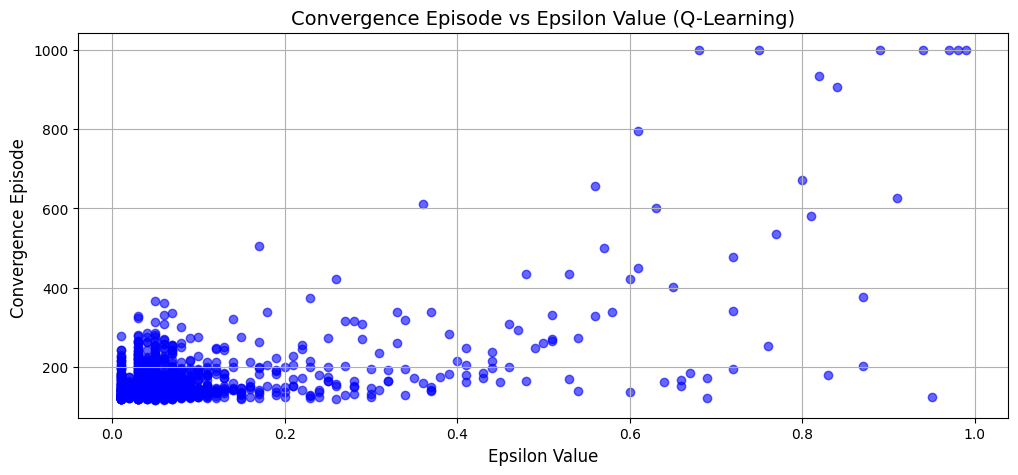

In [ ]:
# Extract the epsilon values and rewards from the study
epsilon_values = [trial.params['epsilon'] for trial in study.trials]
convergence_episode = [trial.value for trial in study.trials]

# Create a scatter plot to visualize performance according to epsilon
plt.figure(figsize=(12, 5))
plt.scatter(epsilon_values, convergence_episode, color='blue', alpha=0.6, label='Performance')

# Add labels and title
plt.title('Convergence Episode vs Epsilon Value (Q-Learning)', fontsize=14)
plt.xlabel('Epsilon Value', fontsize=12)
plt.ylabel('Convergence Episode ', fontsize=12)
plt.grid(True)

# Show the plot
plt.show()


##5.3. Application to Maze without Sub-goal

###5.3.1. Optimal Policy Learned by the Q-Learning Algorithm with Random Epsilon Value

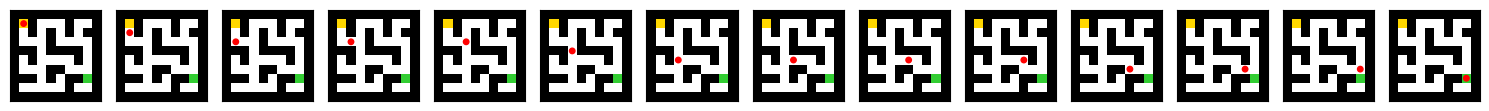

In [ ]:
# Initialize the environment
env_without_subgoal = MazeEnv1()

# Train the agent
q_table, total_rewards, steps_per_episode, convergence_episode, learning_time = simple_q_learning_with_metrics(env_without_subgoal, episodes=250, alpha=0.1, gamma=0.95,
                                                                              epsilon=0.45, convergence_window=50, threshold=0.01)
# Show the agent navigating the maze
demonstrate_optimal_policy(env_without_subgoal, q_table)

###5.3.2. Visualization of the Full Policy Learned by the Q-Learning Algorithm with Random Epsilon Value

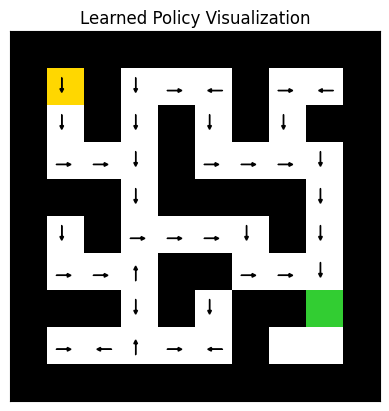

In [ ]:
# Visualize the learned policy
env_without_subgoal.visualize_policy(q_table)

###5.3.3. Plots of Cumulative Reward and Steps per Episode with Random Epsilon Value

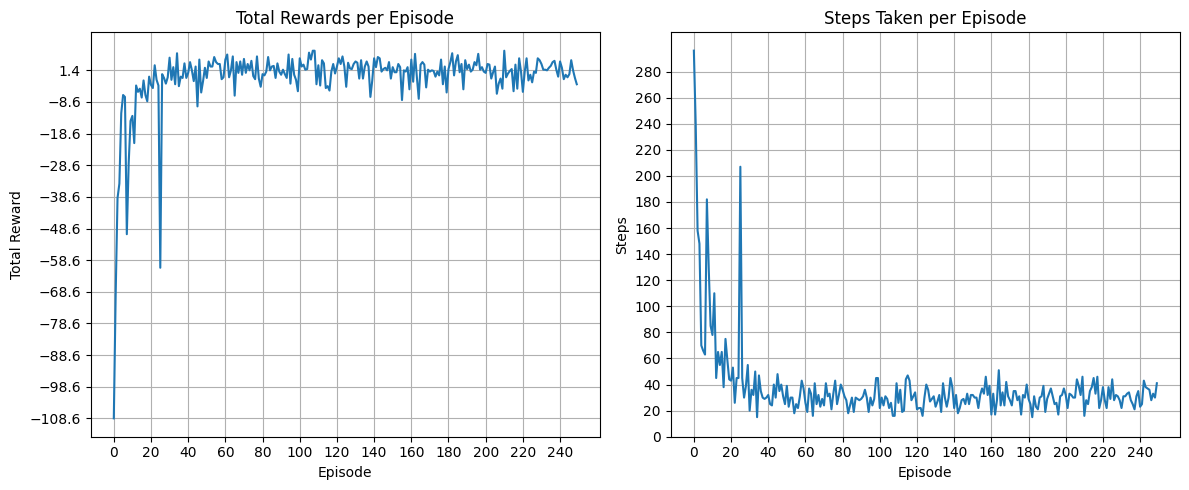

In [ ]:
# Plot cumulative reward and steps over the number of episodes
plot_metrics(total_rewards, steps_per_episode)

### 5.3.4. The Convergence Episode & The Time Required for Convergence with Random Epsilon Value

In [ ]:
# Print the convergence episode
print(f"Episode of convergence: {convergence_episode}")
# Print the time required for convergence
print(f"Time required for convergence: {learning_time:.4f} seconds")

Episode of convergence: 157
Time required for convergence: 0.1158 seconds


## 5.4. Application to  Maze with Sub-goal

###5.4.1. Optimal Policy Learned by the Q-Learning Algorithm with Random Epsilon Value

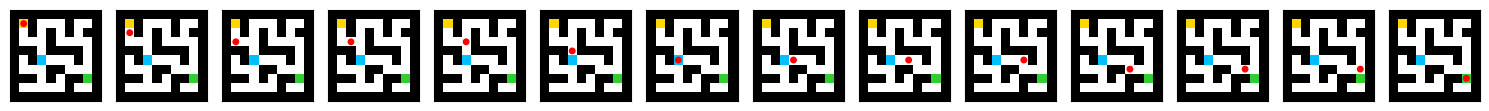

In [ ]:
# Initialize the environment
env_with_subgoal = MazeEnv2()

# Train the agent
q_table, total_rewards, steps_per_episode, convergence_episode, learning_time = simple_q_learning_with_metrics(env_with_subgoal, episodes=250, alpha=0.1, gamma=0.95,
                                                                              epsilon=0.45, convergence_window=50, threshold=0.01)

# Show the agent navigating the maze
demonstrate_optimal_policy(env_with_subgoal, q_table)

###5.4.2. Visualization of the Full Policy Learned by the Q-Learning Algorithm with Random Epsilon Value

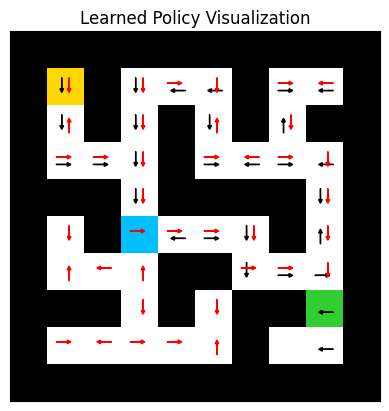

In [ ]:
# Visualize the learned policy
env_with_subgoal.visualize_policy(q_table)

###5.4.3. Plots of Cumulative Reward and Steps per Episode with Random Epsilon Value

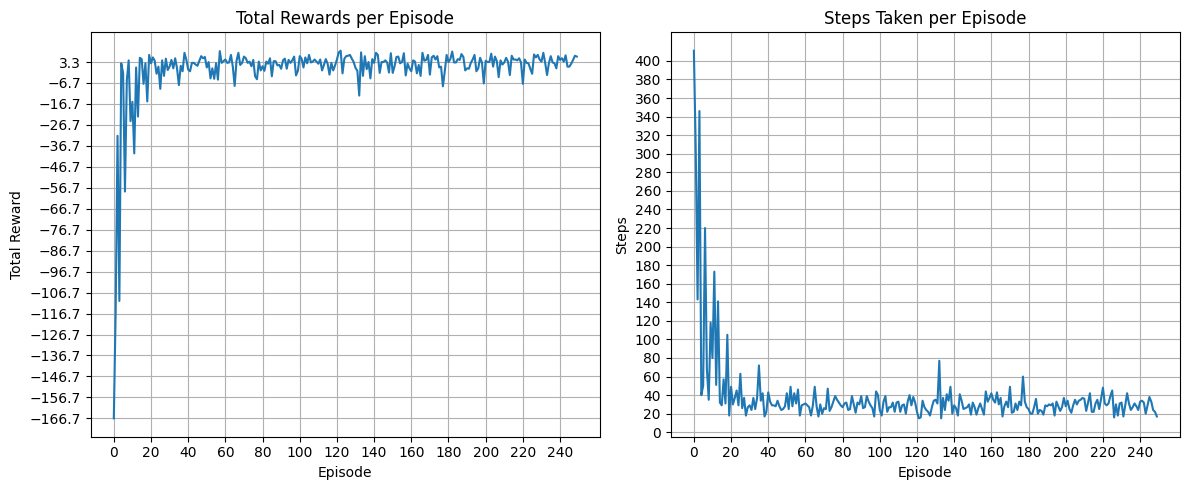

In [ ]:
# Plot cumulative reward and steps over the number of episodes
plot_metrics(total_rewards, steps_per_episode)

### 5.4.4. The Convergence Episode & The Time Required for Convergence with Random Epsilon Value

In [ ]:
# Print the convergence episode
print(f"Episode of convergence: {convergence_episode}")
# Print the time required for convergence
print(f"Time required for convergence: {learning_time:.4f} seconds")

Episode of convergence: 161
Time required for convergence: 0.1422 seconds


###5.4.5. Optimal Policy Learned by the Q-Learning Algorithm with Optimized Epsilon Value

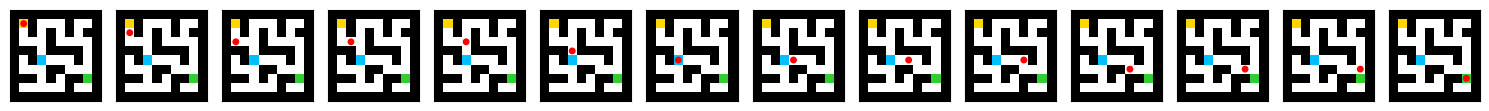

In [ ]:
# Initialize the environment
env_with_subgoal = MazeEnv2()

# Train the agent
q_table, total_rewards, steps_per_episode, convergence_episode, learning_time = simple_q_learning_with_metrics(env_with_subgoal, episodes=250, alpha=0.1, gamma=0.95,
                                                                              epsilon=0.05, convergence_window=50, threshold=0.01)

# Show the agent navigating the maze
demonstrate_optimal_policy(env_with_subgoal, q_table)

###5.4.6. Visualization of the Full Policy Learned by the Q-Learning Algorithm with Optimized Epsilon Value

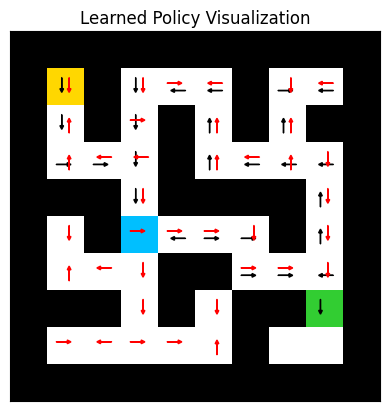

In [ ]:
# Visualize the learned policy
env_with_subgoal.visualize_policy(q_table)

###5.4.7. Plots of Cumulative Reward and Steps per Episode with Optimized Epsilon Value

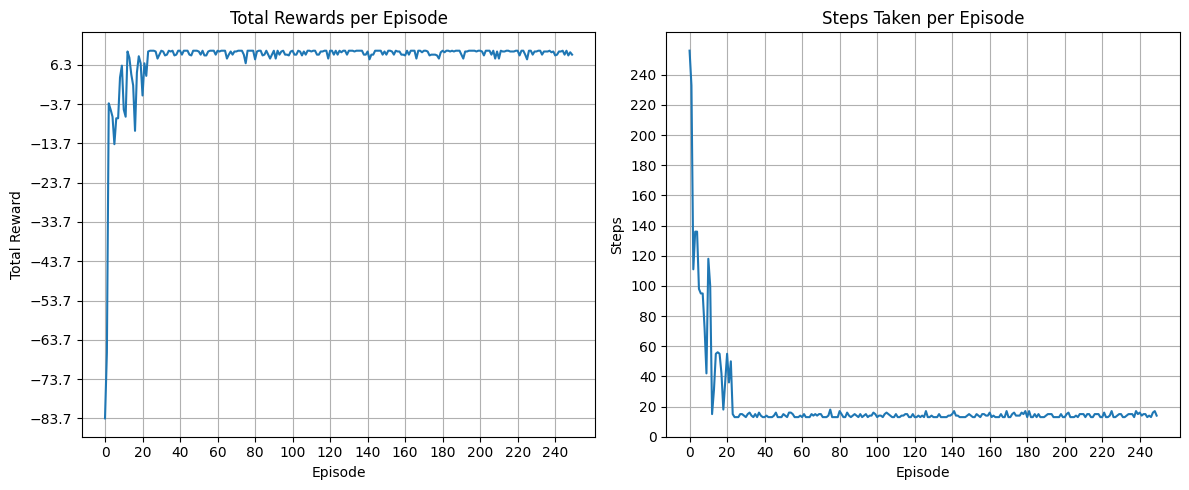

In [ ]:
# Plot cumulative reward and steps over the number of episodes
plot_metrics(total_rewards, steps_per_episode)

### 5.4.8. The Convergence Episode & The Time Required for Convergence with Optimized Epsilon Value

In [ ]:
# Print the convergence episode
print(f"Episode of convergence: {convergence_episode}")
# Print the time required for convergence
print(f"Time required for convergence: {learning_time:.4f} seconds")

Episode of convergence: 136
Time required for convergence: 0.1265 seconds


#6. Value Iteration Algorithm

In [ ]:
def value_iteration(env, gamma=0.95, theta=1e-6):
    """
    Performs Value Iteration for the given environment with a timer to measure convergence time.

    This function applies the Value Iteration algorithm to solve the Markov Decision Process (MDP)
    in the given environment. The algorithm computes the optimal value function by iteratively
    updating the value estimates for each state based on the maximum expected reward. It stops
    once the change in the value function (delta) falls below a convergence threshold (theta).

    Args:
        env: The environment instance, which must provide `step`, `reset`, `observation_space`, and
             `action_space` properties and methods (e.g., compatible with OpenAI Gym environments).
        gamma (float): Discount factor (0 <= gamma <= 1) that determines the importance of future rewards.
        theta (float): Threshold for the convergence of value function updates. If the change in value
                       for all states is below this threshold, the algorithm stops.

    Returns:
        tuple: A tuple containing the following elements:
            - numpy.ndarray: The final value table representing the maximum expected reward for each state.
            - numpy.ndarray: The Q-table storing the action-value pairs for each state-action combination.
            - numpy.ndarray: The optimal policy derived from the value function.
            - list: A list tracking the maximum change (delta) in the value function at each iteration.
            - float: The time taken to converge.
    """
    # Start the timer
    start_time = time.time()

    # Initialize the value table with zeros
    value_table = np.zeros(env.observation_space.n)
    # Initialize the Q-table with zeros
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    # Track the maximum change in value function (delta) per iteration
    max_value_changes_per_iteration = []

    # Loop until the value function converges
    while True:
        # Keep track of value function change
        delta = 0

        # Iterate over all possible states
        for state in range(env.observation_space.n):

            # Loop over all actions for the current state
            for action in range(env.action_space.n):
                # Convert the state to (x, y) coordinates for the environment
                x, y = divmod(state % 100, 10)
                # Set the environment's agent position
                env.position = (x, y)
                # Set subgoal status based on state
                env.sub_goal_visited = (state >= 100)

                # Take the action and observe the new state, reward, and whether it's done
                new_state, reward, done, _ = env.step(action)
                # Compute Q-value for this action
                q_value = reward + gamma * value_table[new_state]
                # Store Q-value in the Q-table
                q_table[state, action] = q_value

            # Get the max Q-value for the current state
            new_value = max(q_table[state, :])
            # Update delta if change is larger
            delta = max(delta, abs(new_value - value_table[state]))
            # Set the updated value for the state
            value_table[state] = new_value

        # Store the maximum change (delta) for this iteration
        max_value_changes_per_iteration.append(delta)
        # If the value function has converged, exit the loop
        if delta < theta:
            break

    # End the timer and calculate the elapsed time
    end_time = time.time()
    iteration_time = end_time - start_time

    # Initialize the policy table with zeros
    policy = np.zeros(env.observation_space.n, dtype=int)
    # Derive the optimal policy from the Q-table
    for state in range(env.observation_space.n):
        # Get the action with the highest Q-value for each state
        policy[state] = np.argmax(q_table[state])

    return value_table, q_table, policy, max_value_changes_per_iteration, iteration_time


## 6.1. Function for Plotting the Maximum Value Change per Iteration

In [ ]:
def plot_convergence(max_value_changes_per_iteration):
    """Plots the convergence of the Value Iteration algorithm.

    This function visualizes how the maximum change in the value function (delta) evolves
    over iterations during the Value Iteration process. The plot shows the maximum value
    function change at each iteration, providing insight into how quickly the algorithm converges.

    Args:
        max_value_changes_per_iteration (list or array-like): A list or array containing the
            maximum change (delta) in the value function for each iteration of the algorithm.

    Returns:
        None: This function does not return a value but displays a plot.
    """
    # Create a figure
    plt.figure(figsize=(12, 5))

    # Plot delta (max value function change) over the number of iterations
    plt.plot(max_value_changes_per_iteration)

    # Set the ticks (labels) on the x-axis to show every 10th iteration
    plt.xticks(np.arange(0, len(max_value_changes_per_iteration), step=10))
    # Set the ticks (labels) on the y-axis, with steps of 1.5
    plt.yticks(np.arange(0, max(max_value_changes_per_iteration), step=1.5)) # update for the y-axis (change step for more or less values on the axes)

    # Label the axes
    plt.xlabel('Iterations')
    plt.ylabel('Max Value Function Change (Delta)')
    # Set the title
    plt.title('Max Value Function Change per Iteration')

    # Enable the grid for better readability
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()

## 6.2. Application to  Maze without Sub-goal

###6.2.1. Optimal Policy Learned by the Value Iteration Algorithm

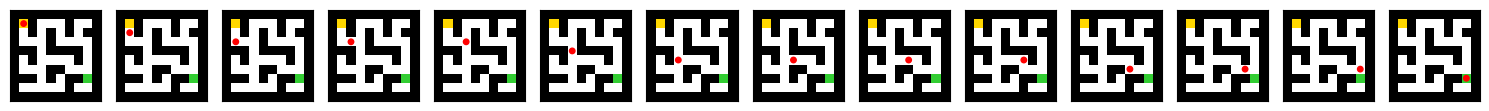

In [ ]:
# Initialize the environment
env_without_subgoal = MazeEnv1()

# Train the Agent
value_table, q_table, policy, max_value_changes_per_iteration, iteration_time = value_iteration(env_without_subgoal, gamma=0.95, theta=1e-6)

# Show the agent navigating the maze
demonstrate_optimal_policy(env_without_subgoal, q_table)

###6.2.2. Visualization of the Full Policy Learned by the Value Iteration Algorithm

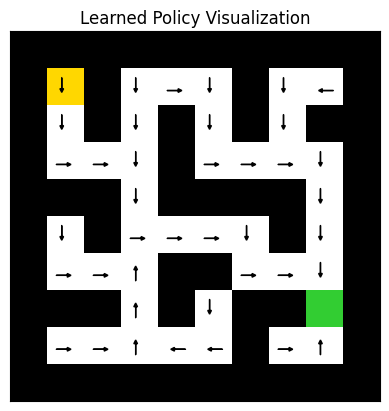

In [ ]:
# Visualize the learned policy
env_without_subgoal.visualize_policy(q_table)

###6.2.3. Plot of Maximum Value Change per Iteration

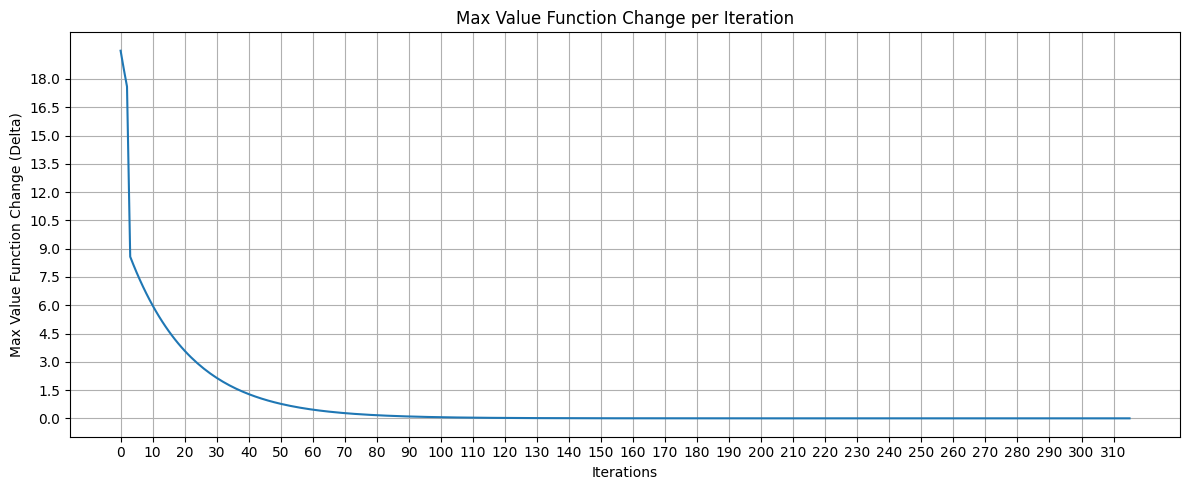

In [ ]:
# Plot the maximum value changes over the number of iterations
plot_convergence(max_value_changes_per_iteration)

### 6.2.4. The Convergence Iteration & The Time Required for Convergence

In [ ]:
# Compute the convergence iteration
convergence_iteration = len(max_value_changes_per_iteration) - 1
# Print the convergence iteration
print(f"Iteration of convergence: {convergence_iteration}")
# Print the time required for convergence
print(f"Time required for convergence: {iteration_time:.4f} seconds")

Iteration of convergence: 315
Time required for convergence: 0.3614 seconds


## 6.3. Application to Maze with Sub-goal

###6.3.1. Optimal Policy Learned by the Value Iteration Algorithm

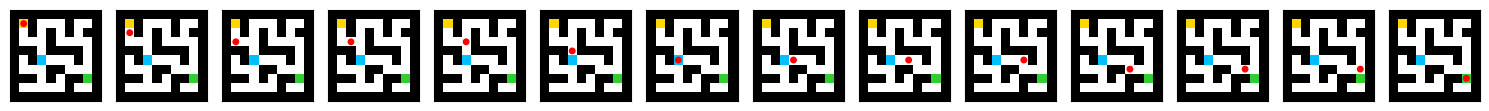

In [ ]:
# Initialize the environment
env_with_subgoal = MazeEnv2()

# Train the Agent
value_table, q_table, policy, max_value_changes_per_iteration, iteration_time = value_iteration(env_with_subgoal, gamma=0.95, theta=1e-6)

# Show the agent navigating the maze
demonstrate_optimal_policy(env_with_subgoal, q_table)

###6.3.2. Visualization of the Full Policy Learned by the Value Iteration Algorithm

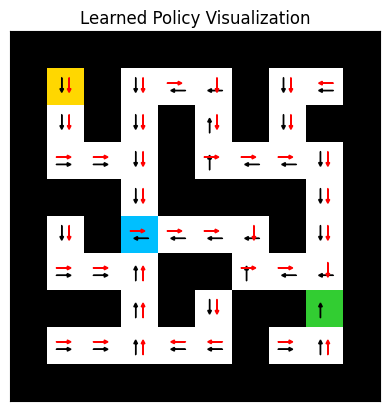

In [ ]:
# Visualize the learned policy
env_with_subgoal.visualize_policy(q_table)

###6.3.3. Plot of Maximum Value Change per Iteration

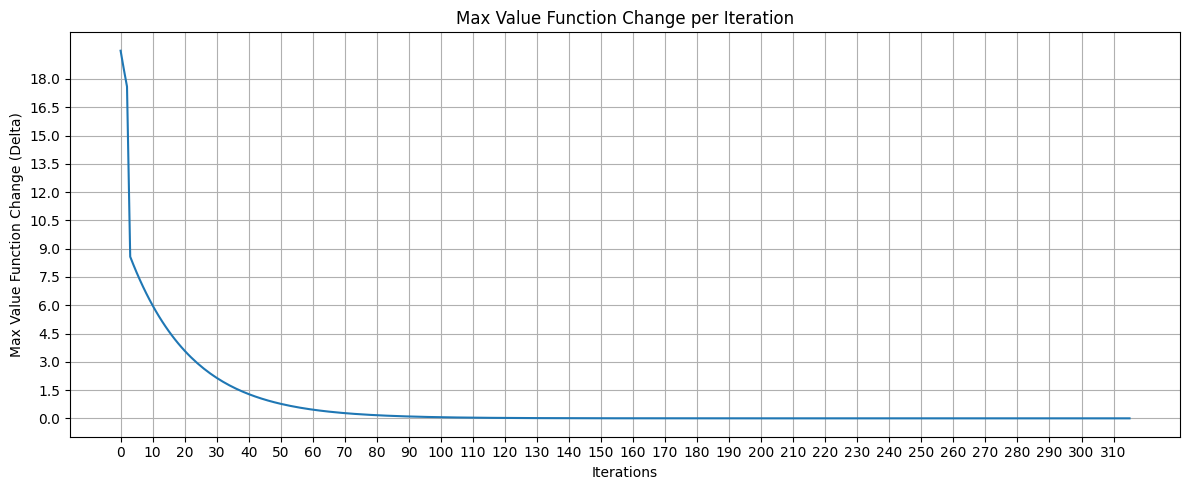

In [ ]:
# Plot the maximum value changes over the number of iterations
plot_convergence(max_value_changes_per_iteration)

### 6.3.4. The Convergence Iteration & The Time Required for Convergence

In [ ]:
# Compute the convergence iteration
convergence_iteration = len(max_value_changes_per_iteration) - 1
# Print the convergence iteration
print(f"Iteration of convergence: {convergence_iteration}")
# Print the time required for convergence
print(f"Time required for convergence: {iteration_time:.4f} seconds")

Iteration of convergence: 315
Time required for convergence: 0.7459 seconds


#7. Checks for Both Algorithm with Different Position of the Sub-goal in the Maze

In [ ]:
# Ensure the previous subgoal is turned into a path
previous_sub_goal_pos = (5, 3)
maze[previous_sub_goal_pos] = PATH

# Change the position of the subgoal
sub_goal_pos = (3, 8)
maze[sub_goal_pos] = SUB_GOAL

## 7.1. Q-Learning

 ### 7.1.1. Optimal Policy Learned by the Q-Learning Algorithm with Optimized Epsilon Value

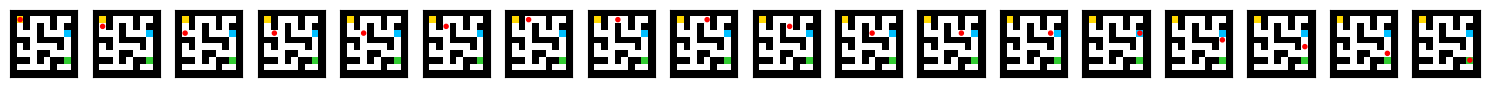

In [ ]:
# Initialize the environment
env_with_subgoal = MazeEnv2()

# Train the agent
q_table, total_rewards, steps_per_episode, convergence_episode, learning_time = simple_q_learning_with_metrics(env_with_subgoal, episodes=250, alpha=0.1, gamma=0.95,
                                                                              epsilon=0.05, convergence_window=50, threshold=0.01)

# Show the agent navigating the maze
demonstrate_optimal_policy(env_with_subgoal, q_table)

### 7.1.2. Visualization of the Full Policy Learned by the Q-Learning Algorithm with Optimized Epsilon Value

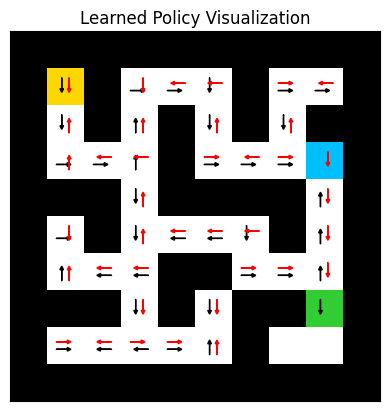

In [ ]:
# Visualize the learned policy
env_with_subgoal.visualize_policy(q_table)

### 7.1.3. Plots of Cumulative Reward and Steps per Episode with Optimized Epsilon Value

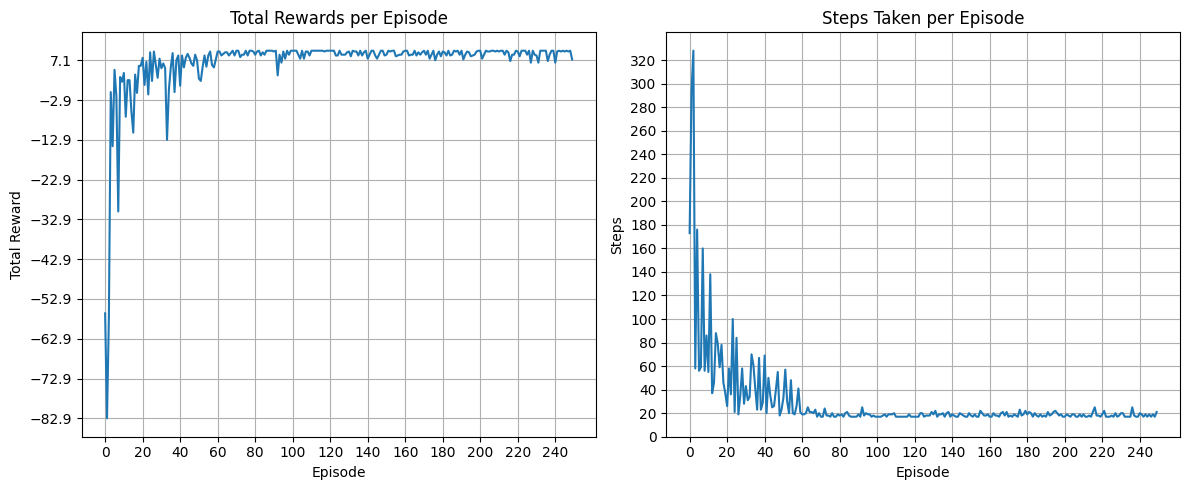

In [ ]:
# Plot cumulative reward and steps over the number of episodes
plot_metrics(total_rewards, steps_per_episode)

### 7.1.4. The Convergence Episode & The Time Required for Convergence with Optimized Epsilon Value

In [ ]:
# Print the convergence episode
print(f"Episode of convergence: {convergence_episode}")
# Print the time required for convergence
print(f"Time required for convergence: {learning_time:.4f} seconds")

Episode of convergence: 169
Time required for convergence: 0.2128 seconds


# 7.2. Value Iteration

### 7.2.1. Optimal Policy Learned by the Value Iteration Algorithm

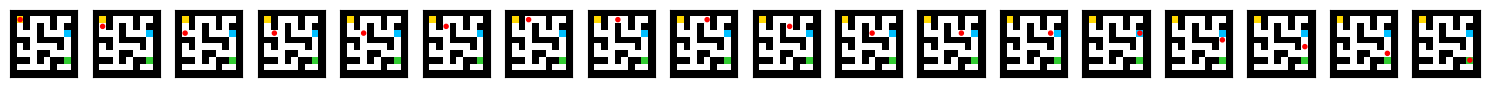

In [ ]:
# Initialize the environment
env_with_subgoal = MazeEnv2()

# Train the agent
value_table, q_table, policy, max_value_changes_per_iteration, iteration_time = value_iteration(env_with_subgoal, gamma=0.95, theta=1e-6)

# Show the agent navigating the maze
demonstrate_optimal_policy(env_with_subgoal, q_table)

###7.2.2. Visualization of the Full Policy Learned by the Value Iteration Algorithm

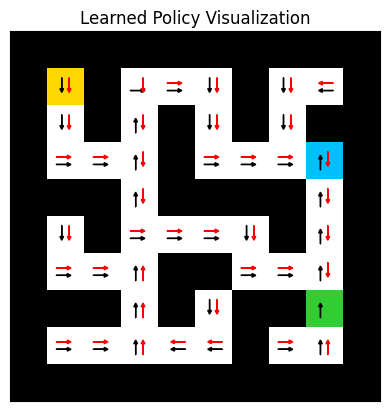

In [ ]:
# Visualize the learned policy
env_with_subgoal.visualize_policy(q_table)

###7.2.3. Plot of Maximum Value Change per Iteration

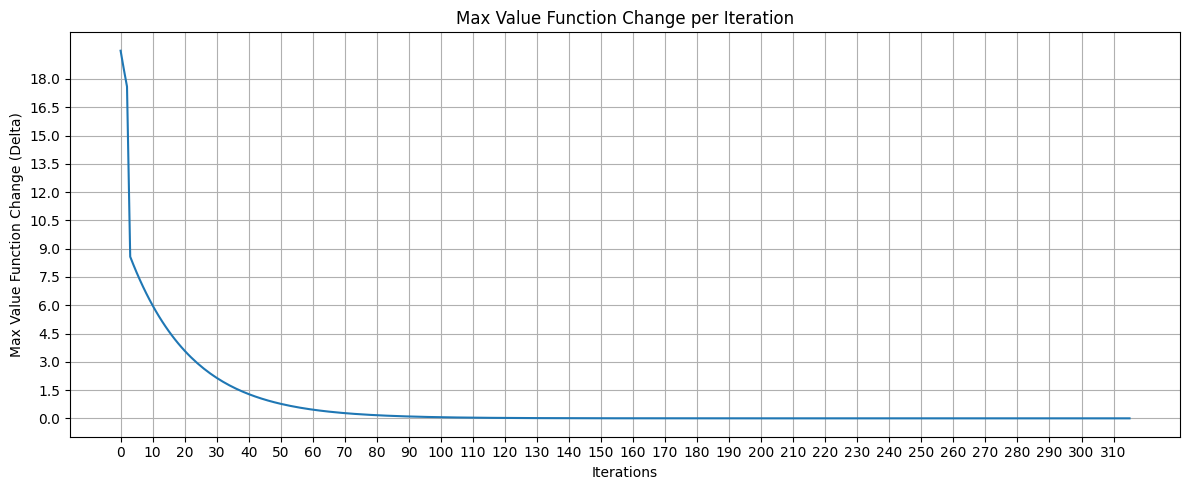

In [ ]:
# Plot the maximum value changes over the number of iterations
plot_convergence(max_value_changes_per_iteration)

### 7.2.4. The Convergence Iteration & The Time Required for Convergence

In [ ]:
# Compute the convergence iteration
convergence_iteration = len(max_value_changes_per_iteration) - 1
# Print the convergence iteration
print(f"Iteration of convergence: {convergence_iteration}")
# Print the time required for convergence
print(f"Time required for convergence: {iteration_time:.4f} seconds")

Iteration of convergence: 315
Time required for convergence: 0.7321 seconds
